# Feed Forward neural network

Building a feed forward neural network with a single scalar input, from scratch!

* Create a neural network using Python dictionaries to store weights
* Add forward propagation code
* Add backpropagation code
* Use it to predict a sine wave
* Add more layers and show how the sine wave prediction improves.

In [33]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.contrib import rnn
import pprint
pp = pprint.PrettyPrinter()

# Create the fake data

a noisy sine curve of 100 points

In [34]:
x_train = sorted(np.random.rand((100)) * 10)
x_test = sorted(np.random.rand((100)) * 10)

In [35]:
noisy_sinusoid = lambda x : x/2 + np.sin(x*3) + np.random.rand()

In [36]:
y_train = [noisy_sinusoid(x) for x in x_train]
y_test = [noisy_sinusoid(x) for x in x_test]

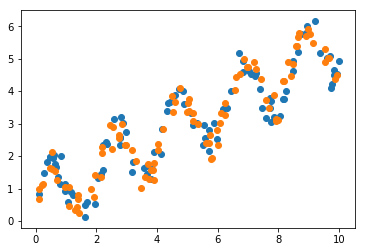

In [37]:
plt.scatter(x_train, y_train)
plt.scatter(x_test, y_test)

# Define a vanilla feedforward neural network with 1 layer

I'm using Python dictionaries to store my layers. We want three types: fc (fully connected), sigmoid and loss.

Basically this is the same as linear regression at this stage but we'll go adding more layers later on.

Define our activation function and its derivative (not used yet!)

In [38]:
def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

In [39]:
def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

Define the network structure. Initially just one fully connected layer and a loss layer.

The fully connected layer will do this:

$$ \hat{y} = W x + b $$

and the loss layer will do

$$ L = (\hat{y} - y)^2 $$

where y-hat are the predicted values of y and y are the true values (as defined in the array initialised above)

So our really simple two-element network does this:

$$ L = (W x + b - y)^2 $$

and to make it accurately predict y, we want to minimise L.

In [40]:
network = [{"type":"fc"}, {"type":"loss"}]

Randomly initialise all parameters

In [41]:
def randomly_initialise_parameters(n):
    for layer in n:
        if layer["type"] == "fc":
            layer["W"] = np.random.normal()
            layer["b"] = np.random.normal()
    pp.pprint(n)
randomly_initialise_parameters(network)

[{'W': 0.478889949332086, 'b': 0.016538009732564012, 'type': 'fc'},
 {'type': 'loss'}]


# Forward and backpropagation

Define the forward propagation function

In [42]:
def forward_prop(x, y = None, save_hidden_layers = False):
    loss = None
    for layer in network:
        if layer["type"] == "fc":
            if save_hidden_layers:
                layer["x"] = x
            x = layer["W"] * x + layer["b"]
        elif layer["type"] == "sigmoid":
            layer["x"] = x
            x = sigmoid(x)
        elif y is not None and layer["type"] == "loss":
            loss = (x - y) * (x - y)
            return x, loss
    return x

We can test the forward propagation using our x and y points. Obviously the network won't do anything useful yet as it's randomly initalised.

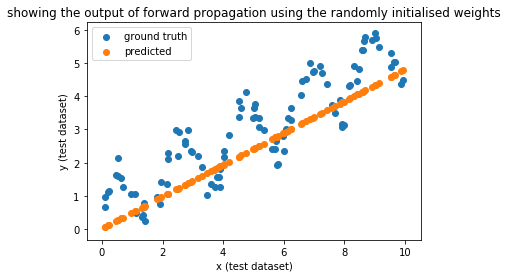

In [43]:
def plot_network_output(title):
    # plot the network's performance on the test data
    plt.scatter(x_test, y_test, label="ground truth")
    plt.scatter(x_test, [forward_prop(x) for x in x_test], label="predicted")
    plt.xlabel("x (test dataset)")
    plt.ylabel("y (test dataset)")
    plt.legend()
    plt.title(title)
    plt.show()
plot_network_output("showing the output of forward propagation using the randomly initialised weights")

Here is the hardest part to understand: the backpropagation.
    
You need to understand the chain rule to follow this.

For example if the network is as above:

$$ L = (W x + b - y)^2 $$

we want to choose W and b to minimise L.

We can calculate the derivatives

$$ \frac{\partial L}{\partial W} = 2(\hat{y} - y) x $$

$$ \frac{\partial L}{\partial b} = 2(\hat{y} - y) $$

When you have multiple layers in a network, each one will contribute another multiplicative term to the above expression. E.g. a sigmoid will cause the above to be multiplied by something of the form

$$ \sigma(x) (1-\sigma(x)) $$

(in each expression x would be the input to that layer)

So if you have a network of 3 layers, the derivative of the first layer's weight will be

$$ \frac{\partial L}{\partial W_0} = 2(\hat{y} - y) W_2 \sigma(a_1) (1-\sigma(a_1)) W_1 \sigma(a_0)(1-\sigma(a_0)) x $$

and the derivative of the first layer's bias will be

$$ \frac{\partial L}{\partial b_0} = 2(\hat{y} - y) W_2 \sigma(a_1) (1-\sigma(a_1)) W_1 \sigma(a_0)(1-\sigma(a_0)) $$

where a_0 and a_1 are the numbers that go into the sigmoids partway through the network.

In [44]:
def backward_prop(x, y, y_hat, lr):
    chain_rule_derivative = 1
    for how_far_from_end, layer in enumerate(reversed(network)):
        if layer["type"] == "fc":
            db_dx = chain_rule_derivative
            dW_dx = chain_rule_derivative * layer["x"]
            chain_rule_derivative *= layer["W"]
            
            '''
            # calculate numeric derivative
            # (for checking that the chain rule was correctly applied!)
            delta = 0.0001
            W = layer["W"]
            layer["W"] = W + delta
            _, pos_loss = forward_prop(x, y)
            layer["W"] = W - delta
            _, neg_loss = forward_prop(x, y)
            
            numeric_dW_dx = (pos_loss - neg_loss) / 2 / delta
            print ((how_far_from_end, "W", numeric_dW_dx, dW_dx))
            
            
            b = layer["b"]
            layer["b"] = b + delta
            _, pos_loss = forward_prop(x, y)
            layer["b"] = b - delta
            _, neg_loss = forward_prop(x, y)
            
            numeric_db_dx = (pos_loss - neg_loss) / 2 / delta
            print ((how_far_from_end, "b", numeric_db_dx, db_dx))
            
            layer["W"] = W
            ## end
            '''
            
            layer["W"] = layer["W"] - lr * dW_dx
            layer["b"] = layer["b"] - lr * db_dx            
        elif layer["type"] == "sigmoid":
            chain_rule_derivative *= sigmoid_derivative(layer["x"])
        elif y is not None and layer["type"] == "loss":
            chain_rule_derivative *= 2 * (y_hat - y)

In [45]:
def plot_losses(losses):
    # plot the loss against time
    plt.plot(range(len(losses["train"])), losses["train"], label="training loss")
    plt.plot(range(len(losses["test"])), losses["test"], label="test loss")
    plt.xlabel("epoch")
    plt.ylabel("average loss per instance")
    plt.legend()
    plt.title("losses over time")
    plt.show()

# Train the simple single-layer feedforward network

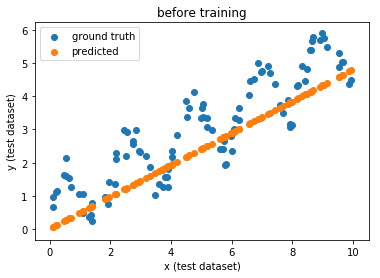

iteration 0 test loss 0.577711769168
iteration 100 test loss 0.588431136219
iteration 200 test loss 0.58843113622
iteration 300 test loss 0.58843113622
iteration 400 test loss 0.58843113622
iteration 500 test loss 0.58843113622
iteration 600 test loss 0.58843113622
iteration 700 test loss 0.58843113622
iteration 800 test loss 0.58843113622
iteration 900 test loss 0.58843113622


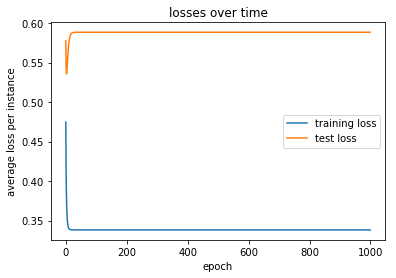

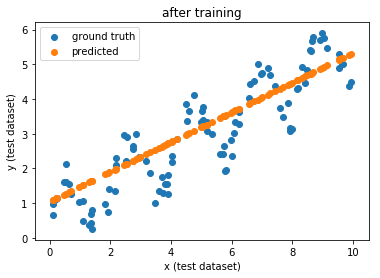

In [46]:
def train(num_epochs = 100, lr=0.001, plot_interval=None):
    plot_network_output("before training")
    losses = {"train":[], "test":[]}
    for iteration in range(num_epochs):
        y_hats = []
        total_loss = 0
        for sample_no in range(len(x_train)):
            x = x_train[sample_no]
            y = y_train[sample_no]
            y_hat, loss = forward_prop(x, y, True)
            backward_prop(x, y, y_hat, lr)
            y_hats.append(y_hat)
            total_loss += loss
        total_loss = total_loss / len(x_train)
        losses["train"].append(total_loss)
        total_loss = 0
        for sample_no in range(len(x_test)):
            x = x_test[sample_no]
            y = y_test[sample_no]
            y_hat, loss = forward_prop(x, y)
            total_loss += loss
        total_loss = total_loss / len(x_test)
        losses["test"].append(total_loss)
        if iteration % (num_epochs / 10) == 0 or (plot_interval is not None and iteration % plot_interval == 0):
            print ("iteration", iteration, "test loss", total_loss)
        if iteration > 0 and plot_interval is not None and iteration % plot_interval == 0:
            plot_network_output("iteration " + str(iteration))
    
    plot_losses(losses)
    plot_network_output("after training")

train(1000, lr=0.01)

# Now try a 3-layer network

[{'W': -1.8679401100205815, 'b': -0.11312582657544529, 'type': 'fc'},
 {'type': 'sigmoid'},
 {'W': 0.15613293736341594, 'b': -0.7343267857425394, 'type': 'fc'},
 {'type': 'sigmoid'},
 {'W': -1.1251034375050009, 'b': -0.44136044266166324, 'type': 'fc'},
 {'type': 'loss'}]


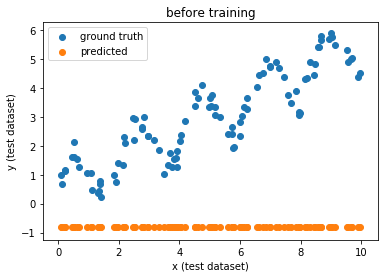

iteration 0 test loss 11.2813666591
iteration 1000 test loss 0.646507444024
iteration 2000 test loss 0.566290848872
iteration 3000 test loss 0.56394311228
iteration 4000 test loss 0.56343047927
iteration 5000 test loss 0.563173845016
iteration 6000 test loss 0.562972673493
iteration 7000 test loss 0.56279397696
iteration 8000 test loss 0.562631705231
iteration 9000 test loss 0.562484462386


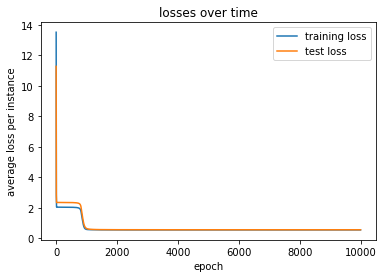

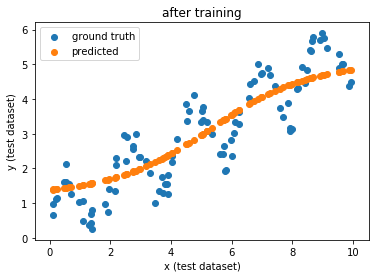

In [47]:
network = [{"type":"fc"}, {"type":"sigmoid"}, {"type":"fc"}, {"type":"sigmoid"}, {"type":"fc"}, {"type":"loss"}]
randomly_initialise_parameters(network)
train(num_epochs=10000)

# Now try more layers

[{'W': 1.0191436148836848, 'b': -0.6728355404573928, 'type': 'fc'},
 {'type': 'sigmoid'},
 {'W': 0.7105389228700014, 'b': 1.0556683320573705, 'type': 'fc'},
 {'type': 'sigmoid'},
 {'W': 0.8374858264542243, 'b': -1.0207347508704154, 'type': 'fc'},
 {'type': 'sigmoid'},
 {'W': -0.7333687251873253, 'b': -0.17992240123299055, 'type': 'fc'},
 {'type': 'sigmoid'},
 {'W': -0.4791363522959493, 'b': -0.07398894047337358, 'type': 'fc'},
 {'type': 'sigmoid'},
 {'W': 0.4729059886052304, 'b': -1.2196066028873942, 'type': 'fc'},
 {'type': 'loss'}]


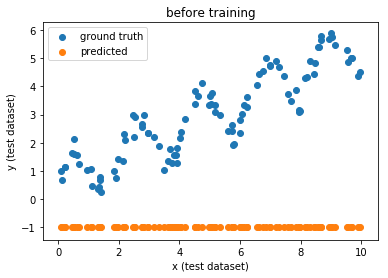

iteration 0 test loss 11.9115085901
iteration 1000 test loss 2.36387492937


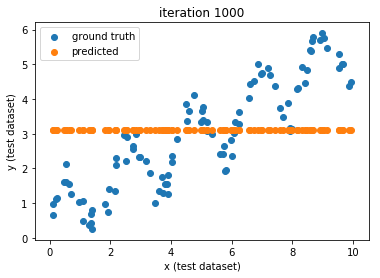

iteration 2000 test loss 2.3636108365


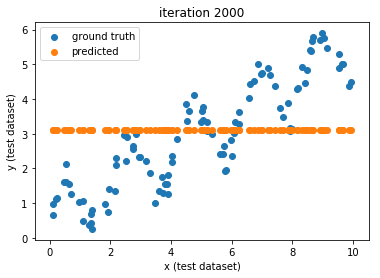

iteration 3000 test loss 2.36331345681


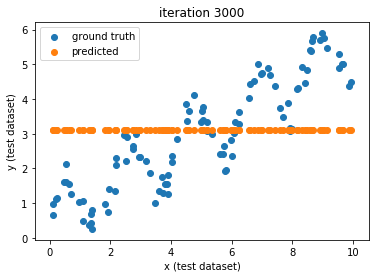

iteration 4000 test loss 2.36296274679


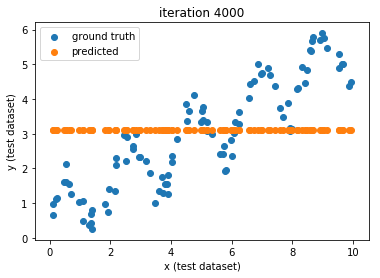

iteration 5000 test loss 2.36251297376


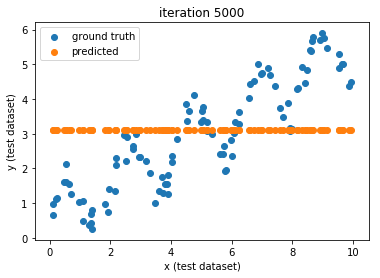

iteration 6000 test loss 2.3618301029


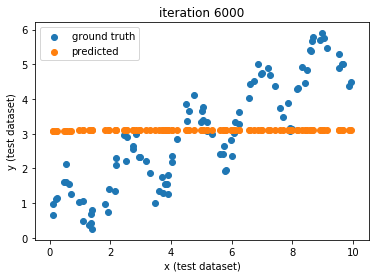

iteration 7000 test loss 2.36030914441


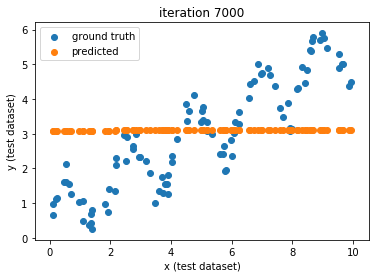

iteration 8000 test loss 2.35068877979


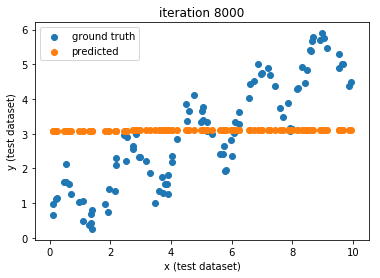

iteration 9000 test loss 0.603111834327


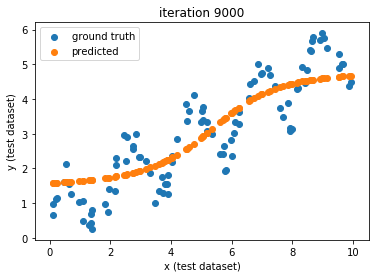

iteration 10000 test loss 0.580898477551


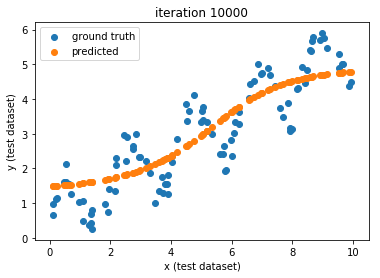

iteration 11000 test loss 0.57740900082


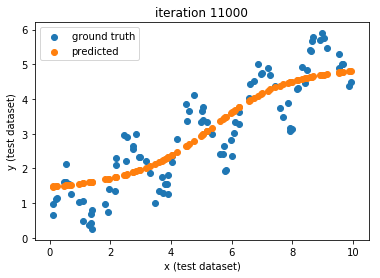

iteration 12000 test loss 0.575701491835


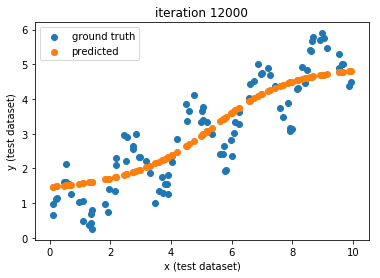

iteration 13000 test loss 0.574743336725


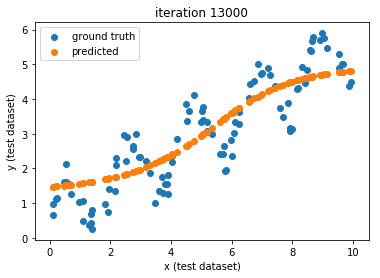

iteration 14000 test loss 0.57419068596


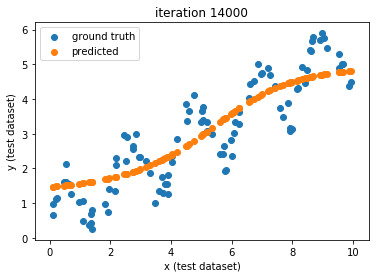

iteration 15000 test loss 0.573874574807


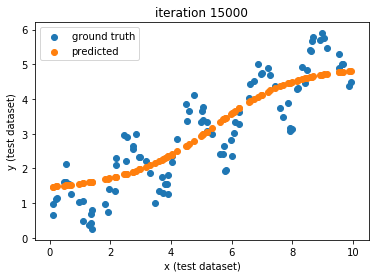

iteration 16000 test loss 0.573699857038


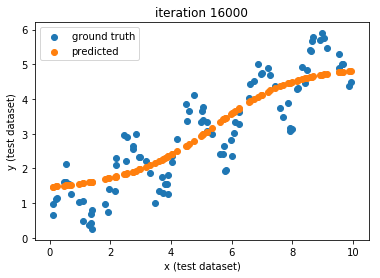

iteration 17000 test loss 0.573608875728


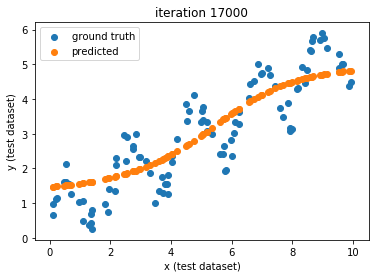

iteration 18000 test loss 0.573565768504


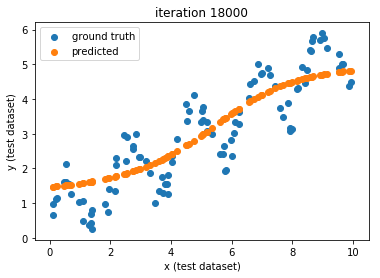

iteration 19000 test loss 0.573548349641


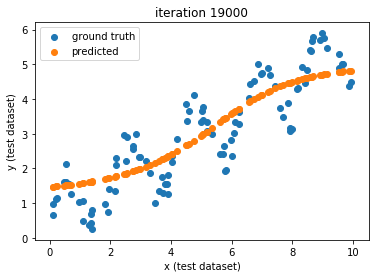

iteration 20000 test loss 0.573543201364


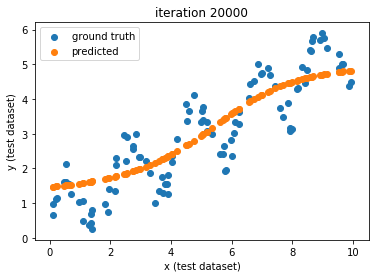

iteration 21000 test loss 0.573542482045


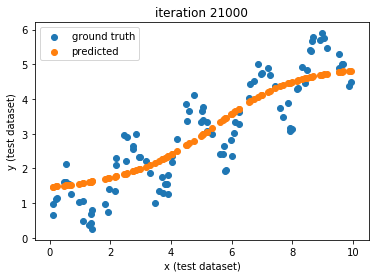

iteration 22000 test loss 0.57354182938


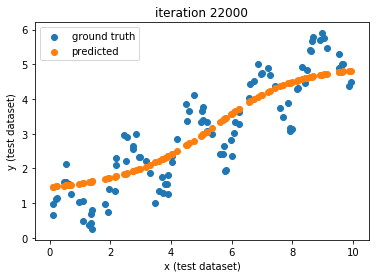

iteration 23000 test loss 0.573539002898


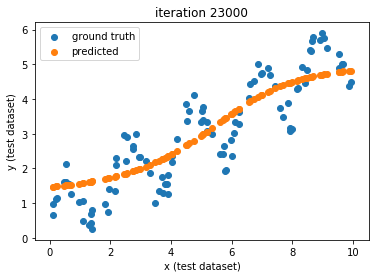

iteration 24000 test loss 0.573533022475


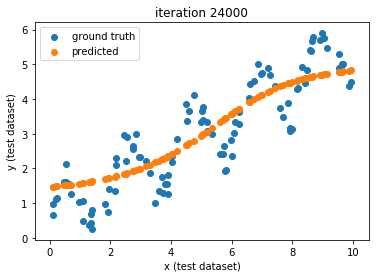

iteration 25000 test loss 0.573523631955


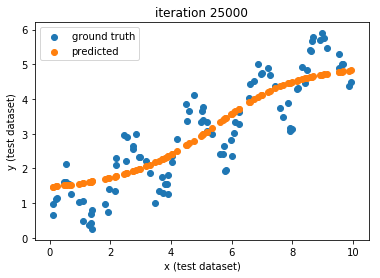

iteration 26000 test loss 0.573510971071


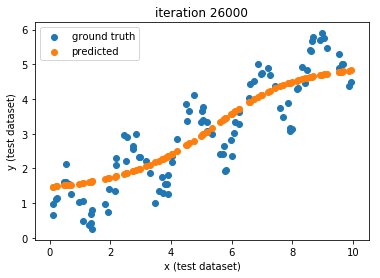

iteration 27000 test loss 0.573495378447


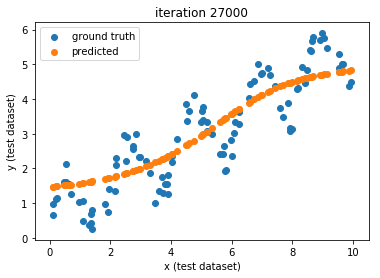

iteration 28000 test loss 0.57347727589


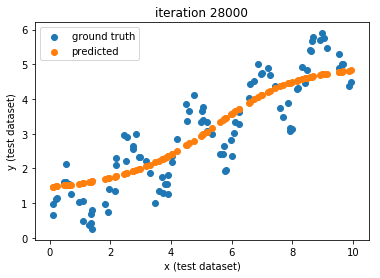

iteration 29000 test loss 0.573457102503


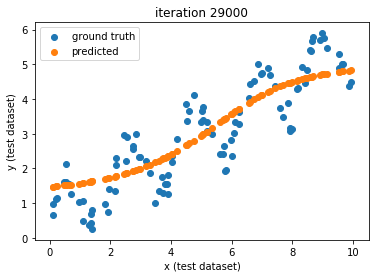

iteration 30000 test loss 0.573435278948


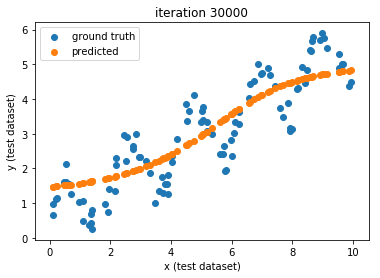

iteration 31000 test loss 0.573412189704


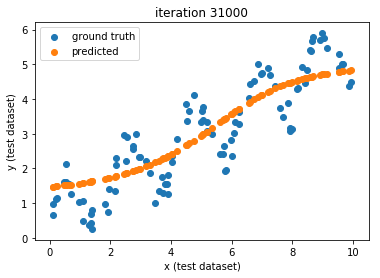

iteration 32000 test loss 0.573388175846


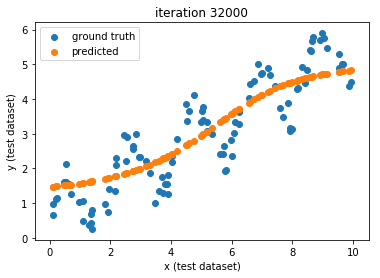

iteration 33000 test loss 0.573363533789


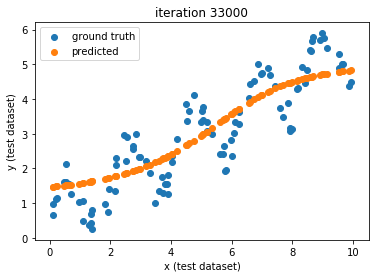

iteration 34000 test loss 0.573338517263


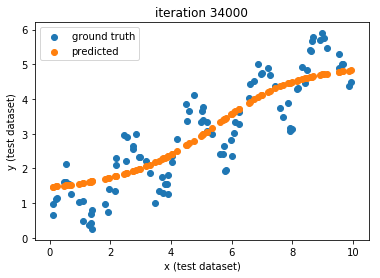

iteration 35000 test loss 0.573313340874


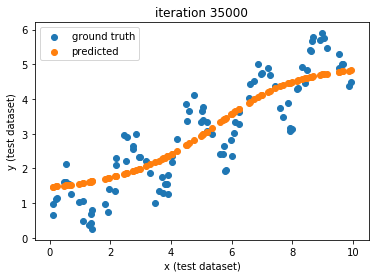

iteration 36000 test loss 0.573288184304


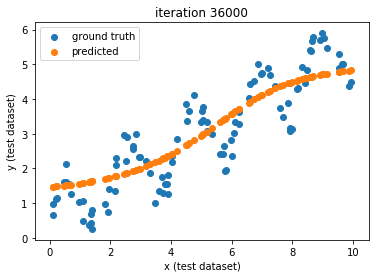

iteration 37000 test loss 0.573263196596


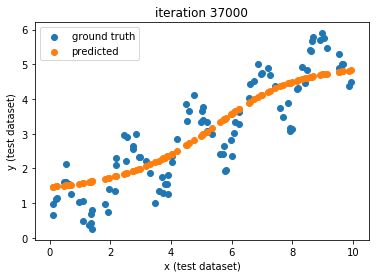

iteration 38000 test loss 0.573238500246


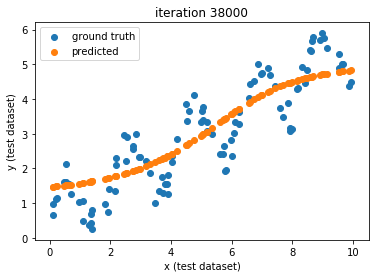

iteration 39000 test loss 0.573214194946


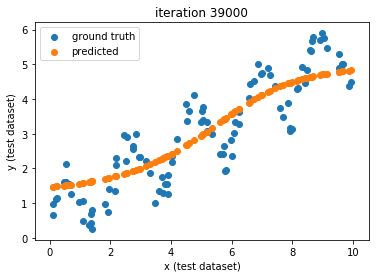

iteration 40000 test loss 0.573190360938


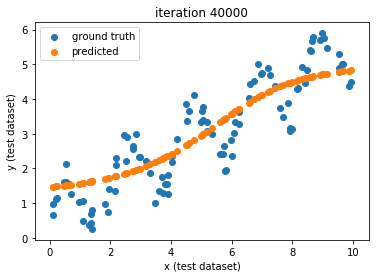

iteration 41000 test loss 0.573167061956


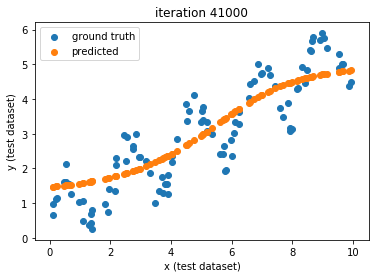

iteration 42000 test loss 0.573144347783


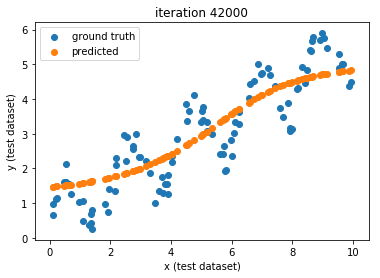

iteration 43000 test loss 0.573122256456


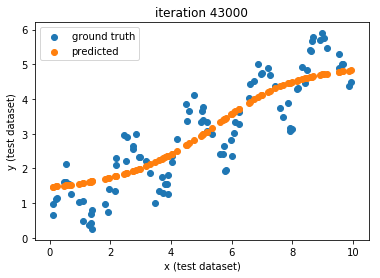

iteration 44000 test loss 0.573100816158


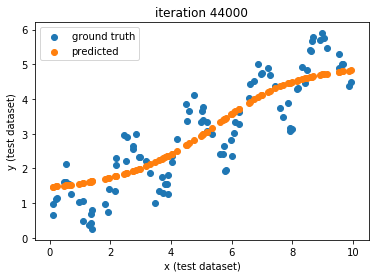

iteration 45000 test loss 0.57308004683


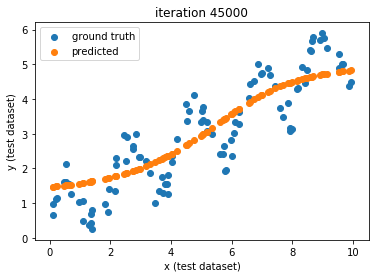

iteration 46000 test loss 0.573059961536


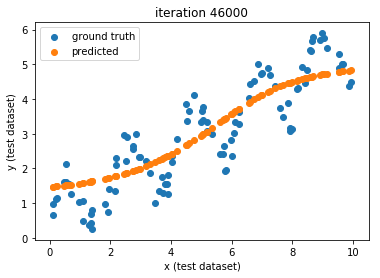

iteration 47000 test loss 0.573040567633


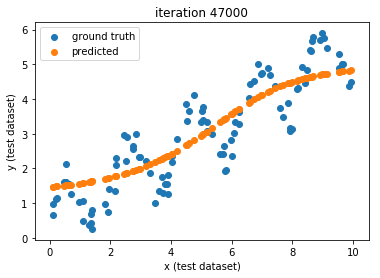

iteration 48000 test loss 0.573021867744


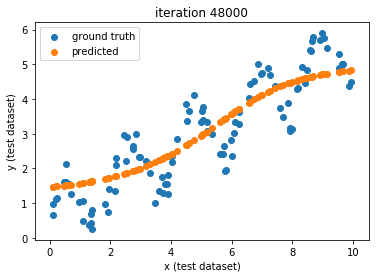

iteration 49000 test loss 0.573003860593


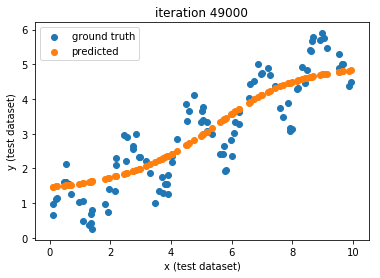

iteration 50000 test loss 0.572986541701


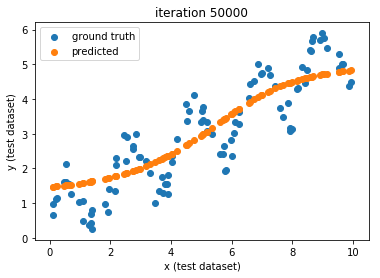

iteration 51000 test loss 0.57296990397


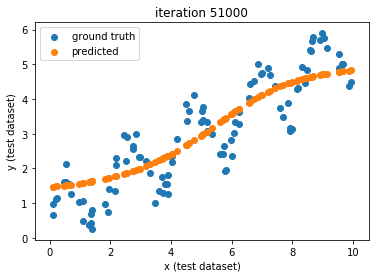

iteration 52000 test loss 0.57295393818


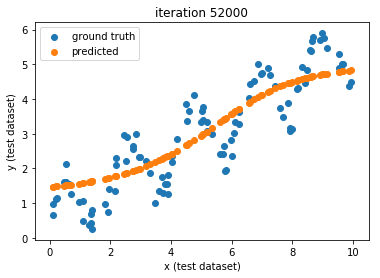

iteration 53000 test loss 0.5729386334


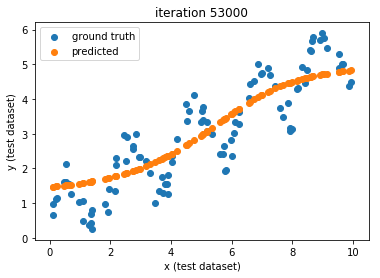

iteration 54000 test loss 0.572923977331


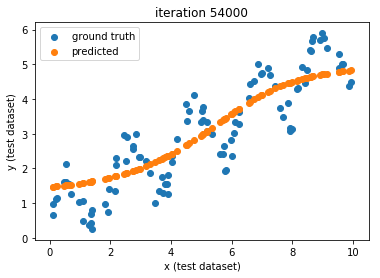

iteration 55000 test loss 0.572909956598


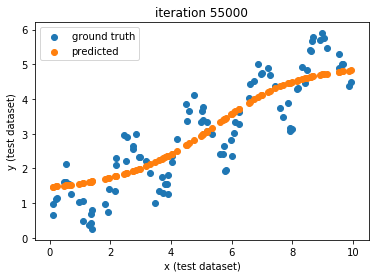

iteration 56000 test loss 0.572896556992


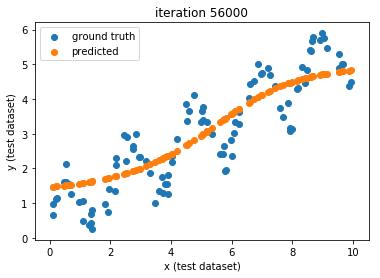

iteration 57000 test loss 0.572883763665


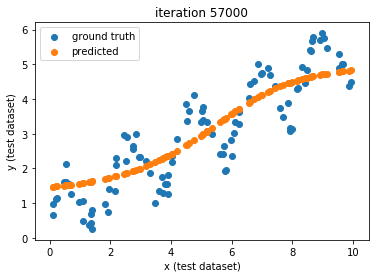

iteration 58000 test loss 0.572871561304


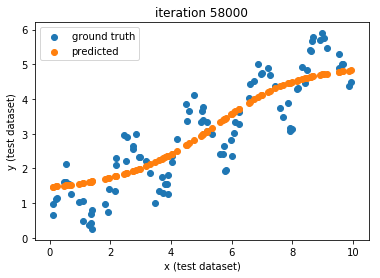

iteration 59000 test loss 0.572859934267


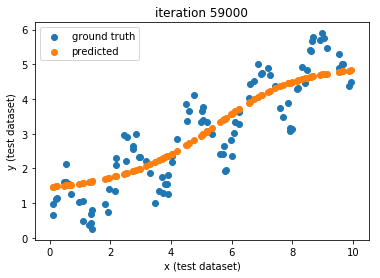

iteration 60000 test loss 0.572848866699


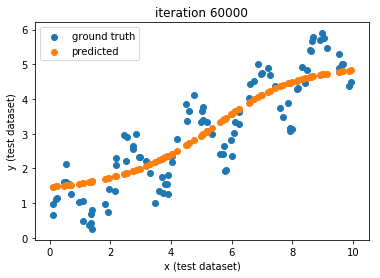

iteration 61000 test loss 0.572838342628


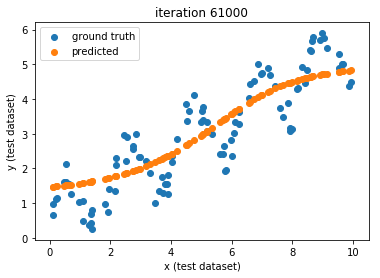

iteration 62000 test loss 0.572828346047


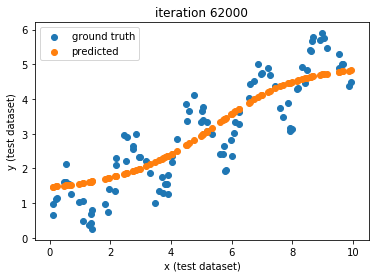

iteration 63000 test loss 0.572818860975


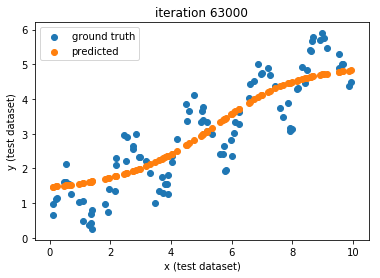

iteration 64000 test loss 0.57280987152


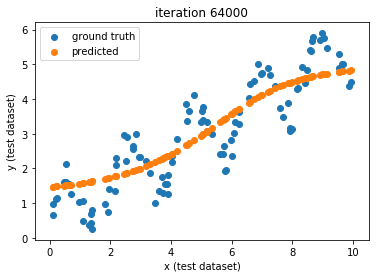

iteration 65000 test loss 0.572801361918


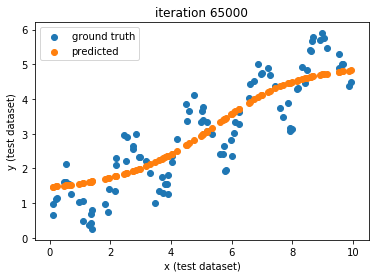

iteration 66000 test loss 0.572793316573


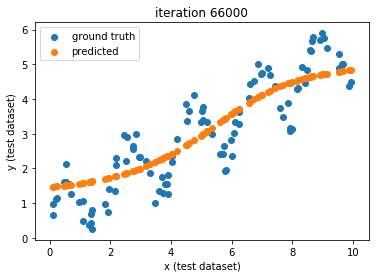

iteration 67000 test loss 0.57278572009


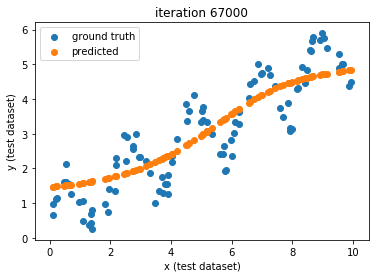

iteration 68000 test loss 0.572778557298


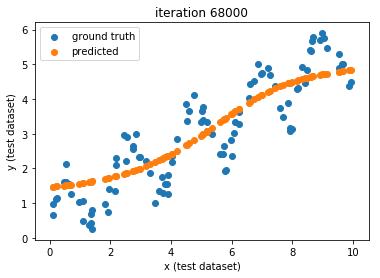

iteration 69000 test loss 0.572771813273


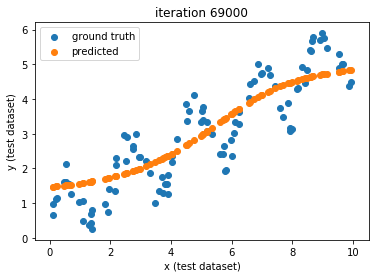

iteration 70000 test loss 0.572765473359


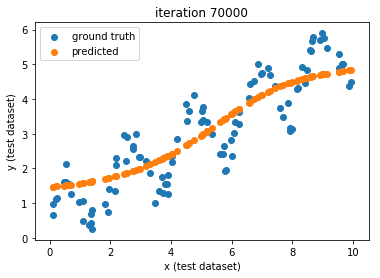

iteration 71000 test loss 0.572759523174


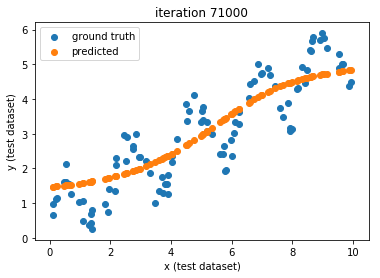

iteration 72000 test loss 0.572753948633


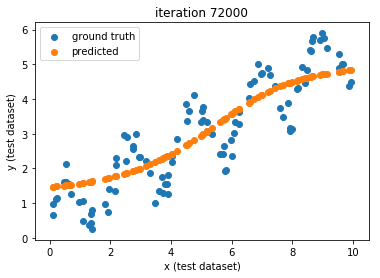

iteration 73000 test loss 0.572748735947


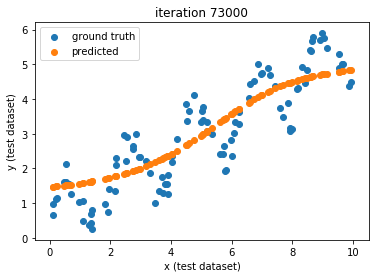

iteration 74000 test loss 0.572743871638


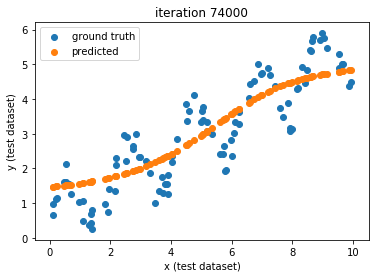

iteration 75000 test loss 0.572739342543


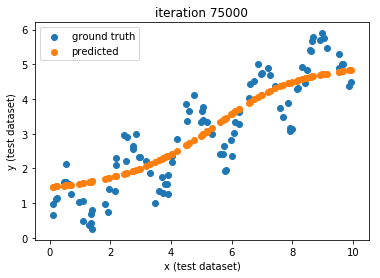

iteration 76000 test loss 0.572735135816


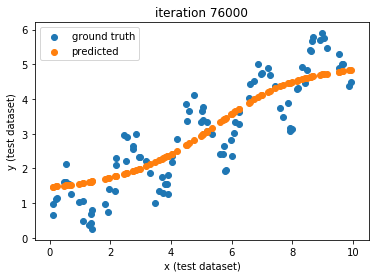

iteration 77000 test loss 0.572731238935


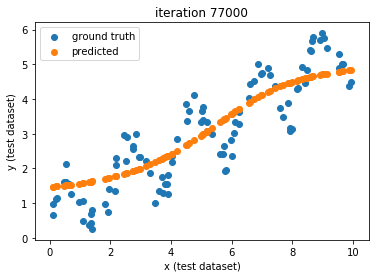

iteration 78000 test loss 0.572727639702


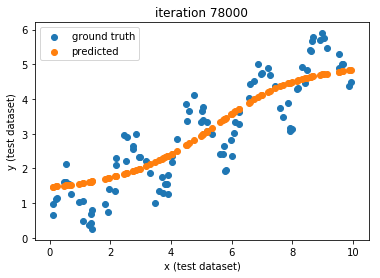

iteration 79000 test loss 0.572724326245


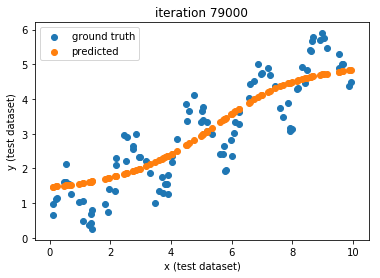

iteration 80000 test loss 0.572721287016


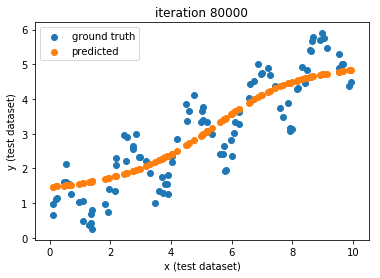

iteration 81000 test loss 0.572718510796


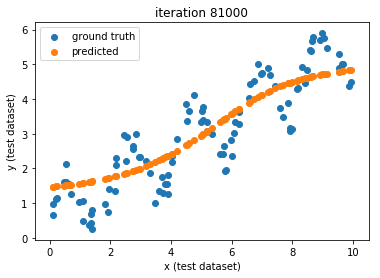

iteration 82000 test loss 0.572715986686


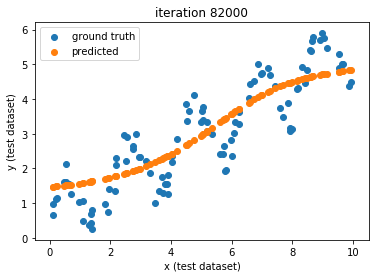

iteration 83000 test loss 0.572713704112


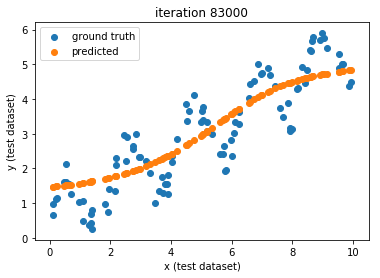

iteration 84000 test loss 0.572711652818


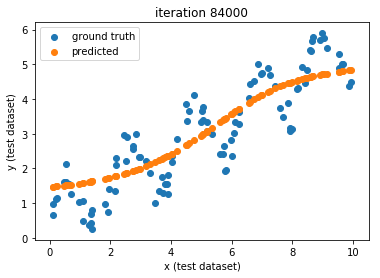

iteration 85000 test loss 0.572709822866


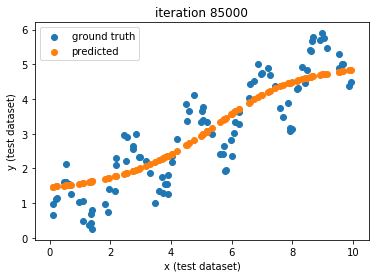

iteration 86000 test loss 0.572708204629


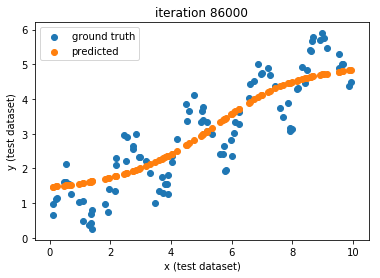

iteration 87000 test loss 0.572706788791


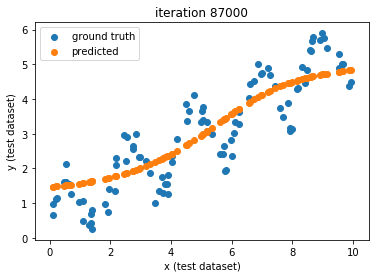

iteration 88000 test loss 0.57270556634


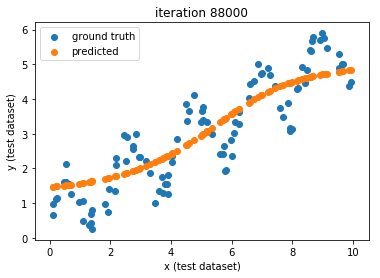

iteration 89000 test loss 0.572704528562


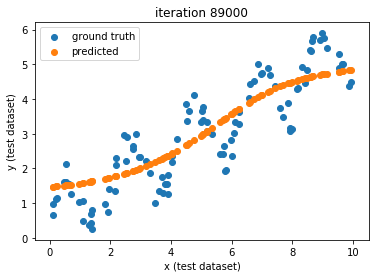

iteration 90000 test loss 0.572703667041


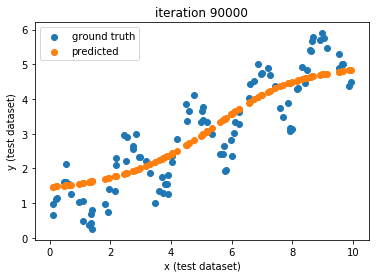

iteration 91000 test loss 0.572702973647


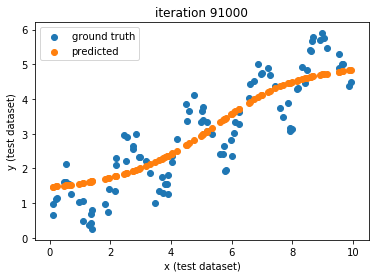

iteration 92000 test loss 0.572702440535


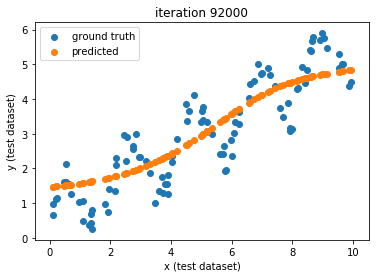

iteration 93000 test loss 0.572702060138


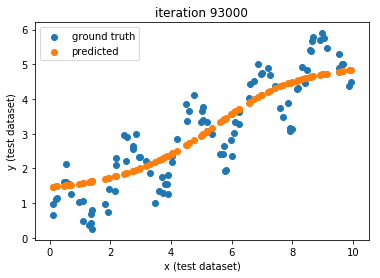

iteration 94000 test loss 0.572701825161


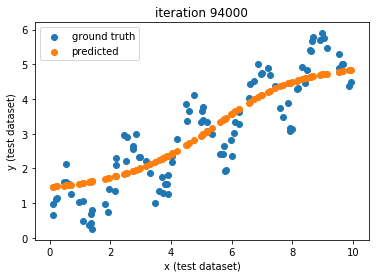

iteration 95000 test loss 0.572701728574


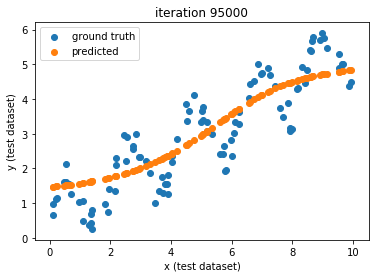

iteration 96000 test loss 0.572701763605


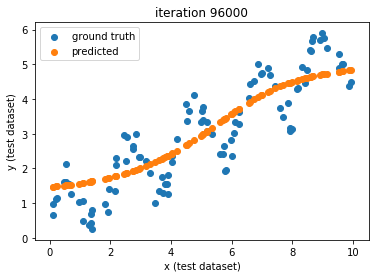

iteration 97000 test loss 0.572701923736


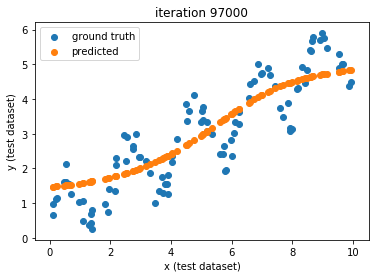

iteration 98000 test loss 0.572702202695


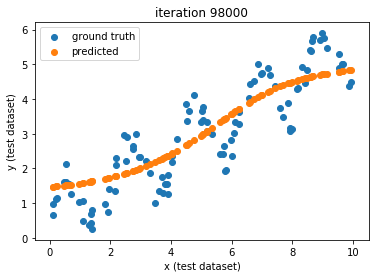

iteration 99000 test loss 0.57270259445


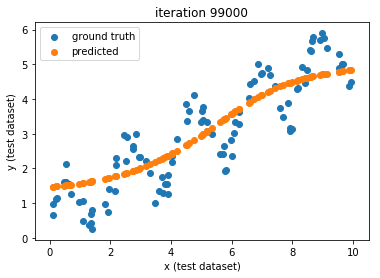

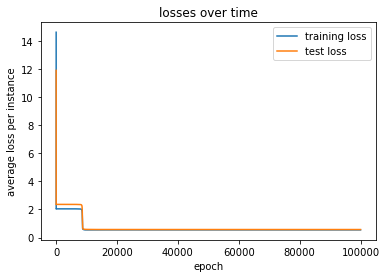

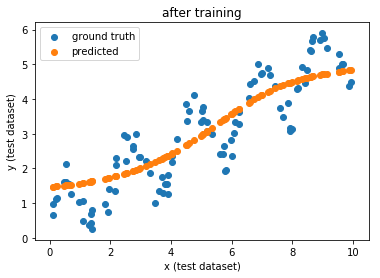

In [48]:
network = [{"type":"fc"}, {"type":"sigmoid"}, {"type":"fc"}, {"type":"sigmoid"}, {"type":"fc"},
           {"type":"sigmoid"}, {"type":"fc"},
           {"type":"sigmoid"}, {"type":"fc"},
           {"type":"sigmoid"}, {"type":"fc"}, {"type":"loss"}]
randomly_initialise_parameters(network)
train(num_epochs=100000, plot_interval=1000)